In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow.keras import models, layers


/Users/sagarpoudel/Desktop/captcha1/xenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip captcha_images_v2.zip
!rm captcha_images_v2.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  2885k      0  0:00:03  0:00:03 --:--:-- 5192k
Archive:  captcha_images_v2.zip
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:

data_dir = Path('/Users/sagarpoudel/Desktop/captcha1/captcha_images_v2')

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'f', 'b', 'p', '5', 'm', 'w', '2', 'n', 'd', 'e', '3', '8', 'y', 'g', 'x', '7', 'c', '6', '4'}


In [4]:

# Mapping characters to integers
from tensorflow.keras.layers import StringLookup

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


In [5]:

def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)

    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(buffer_size=tf.data.AUTOTUNE))

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(batch_size)
                      .prefetch(buffer_size=tf.data.AUTOTUNE))


2024-11-10 22:30:28.893062: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


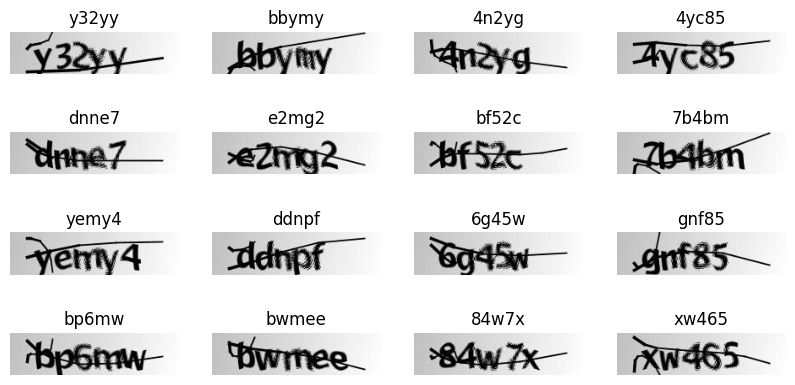

In [6]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [7]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.nn.ctc_loss
    
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length, blank_index=-1)
        self.add_loss(loss)
        return y_pred


In [8]:

def build_model():
    input_img = layers.Input(shape=(img_height, img_width, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = (img_height // 4, img_width // 4 * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model


In [9]:

model = build_model()
model.summary()


ValueError: Exception encountered when calling CTCLayer.call().

[1mCould not automatically infer the output shape / dtype of 'ctc_loss' (of type CTCLayer). Either the `CTCLayer.call()` method is incorrect, or you need to implement the `CTCLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimension must be 3 but is 2 for '{{node ctc_loss_dense/transpose_2}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](ctc_loss_dense/SequenceMask/Cast_1, ctc_loss_dense/transpose_2/perm)' with input shapes: [?,1,?], [2].[0m

Arguments received by CTCLayer.call():
  • args=('<KerasTensor shape=(None, None), dtype=int32, sparse=False, name=label>', '<KerasTensor shape=(None, 12, 128), dtype=float32, sparse=False, name=keras_tensor_8>')
  • kwargs=<class 'inspect._empty'>

In [ ]:

epochs = 100
early_stopping_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])
